Author: Lynn Menchaca

Date: 11Jan2023

Project: Rossmann Stores Sales Forcasting

Resources:

- "How To Guide On Exploratory Data Analysis for Time Series Data" By Mansi Choudhary
    - https://medium.com/analytics-vidhya/how-to-guide-on-exploratory-data-analysis-for-time-series-data-34250ff1d04f
- "ML Algorithm that Natively Supports Missing Values" by Satyam Kumar
    - https://towardsdatascience.com/ml-algorithm-that-natively-supports-missing-values-40b42559c1ec
- "Classification: Missing Data Imputation" by Arthur Adinayev
    - https://arthurarchiproj.medium.com/classification-missing-data-imputation-2932166e1000

#### Project Outline


- EDA - Training Data with Store information
    - Count Plots
    - Sales distribution by product, day, month ...
    - Denoising Techniques to see paterns (moving average, wavelet denoising)
    - format data / intial data questions
- Feature Engineering
    - fill in missing data
    - handel categorical data
    - address outliers

In [1]:
import pandas as pd # data processing
import numpy as np # linear algebra
import seaborn as sns # visualization library
from datetime import datetime

from sklearn.impute import KNNImputer

import matplotlib.pyplot as plt # visualization library
%matplotlib inline

In [2]:
#reading in the Spaceship Titanic data set

data_file_path = '/Users/lynnpowell/Documents/DS_Projects/Data_Files/Rossmann_Store_Sales_Data/'
df_store = pd.read_csv(data_file_path+'store.csv')
df_train = pd.read_csv(data_file_path+'train.csv')
df_test = pd.read_csv(data_file_path+'test.csv')

/var/folders/t3/m14fghtd0fs5gl_s5tzd3h500000gn/T/ipykernel_3045/2558733874.py:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(data_file_path+'train.csv')


In [3]:
# Looking at the train and test data files

print('Train')
print(df_train.head())
print('\n')
print('Test')
print(df_test.head())

Train
   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1  


Test
   Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  SchoolHoliday
0   1      1          4  2015-09-17   1.0      1            0              0
1   2      3          4  2015-09-17   1.0      1            0              0
2   3      7          4  2015-09-17   1.0      1            0              0
3   4      8          4  2015-09-17   1.0      1            0              0
4   5      9 

In [4]:
df_train['StateHoliday'] = df_train['StateHoliday'].str.strip()
df_train['StateHoliday'].value_counts()

0    855087
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [5]:
df_test['StateHoliday'].value_counts()

0    40908
a      180
Name: StateHoliday, dtype: int64

In [6]:
#Store file

print(df_store.shape)
df_store.head()

(1115, 10)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [7]:
# Merging the store dataframe with the train dataframe
# Using train df left merge since the goal is keep all the training data
#matching features train and store: "Store" - unique ID for each store

store_train = pd.merge(df_train, df_store, on='Store', how='left')

store_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [8]:
#Performing the same process on the test df

store_test = pd.merge(df_test, df_store, on='Store', how='left')

store_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN


In [9]:
#Looking for duplicate data in test and train
print('Train Data')
print(store_train[store_train.duplicated()].count())
print('\n')
print('Test Data')
print(store_test[store_test.duplicated()].count())

Train Data
Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64


Test Data
Id                           0
Store                        0
DayOfWeek                    0
Date                         0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Pro

In [10]:
# Idea of null values for training data
# Overview of missing data: count and percentage

train_missing = store_train.isnull().sum()
percent_train_missing = store_train.isnull().sum() * 100 / len(store_train)

missing_train = pd.DataFrame({'Total Missing': train_missing,
                          'Percent Missing': percent_train_missing})
print('Train Data')
missing_train.sort_values(['Total Missing'],ascending=False).head(7)

Train Data


,Total Missing,Percent Missing
PromoInterval,508031,49.943620
Promo2SinceYear,508031,49.943620
Promo2SinceWeek,508031,49.943620
CompetitionOpenSinceYear,323348,31.787764
CompetitionOpenSinceMonth,323348,31.787764
StateHoliday,131072,12.885454
CompetitionDistance,2642,0.259730


In [11]:
test_missing = store_test.isnull().sum()
percent_test_missing = store_test.isnull().sum() * 100 / len(store_train)

missing_test = pd.DataFrame({'Total Missing': test_missing,
                          'Percent Missing': percent_test_missing})
print('Test Data')
missing_test.sort_values(['Total Missing'],ascending=False).head(8)

Test Data


,Total Missing,Percent Missing
PromoInterval,17232,1.694047
Promo2SinceYear,17232,1.694047
Promo2SinceWeek,17232,1.694047
CompetitionOpenSinceYear,15216,1.495858
CompetitionOpenSinceMonth,15216,1.495858
CompetitionDistance,96,0.009438
Open,11,0.001081
Assortment,0,0.000000



Most of the promotion information is missing and some of the competition data is missing from the training data. This gets readdressed in the Feature Engineering section.


In [12]:
store_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               886137 non-null   object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [13]:
#Function to convert and expand the date information
# Source: pandas.Series.dt.'Fill In'

def date_info(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    # Day of week -> Monday=0, Sunday=6
    #df['DayofWeek'] = df['Date'].dt.dayofweek -> already a feature
    #Week of year will be used with Promo2SinceWeek
    df['WeekOfYear']=df.Date.dt.isocalendar().week

In [14]:
date_info(store_train)
date_info(store_test)

date_time = ['Date', 'Year', 'Month', 'Day', 'DayOfWeek', 'WeekOfYear']

print('Data type of Date feature: ', store_train['Date'].dtype)
print(store_train[date_time].head())
print(store_test[date_time].head())

Data type of Date feature:  datetime64[ns]
        Date  Year  Month  Day  DayOfWeek  WeekOfYear
0 2015-07-31  2015      7   31          5          31
1 2015-07-31  2015      7   31          5          31
2 2015-07-31  2015      7   31          5          31
3 2015-07-31  2015      7   31          5          31
4 2015-07-31  2015      7   31          5          31
        Date  Year  Month  Day  DayOfWeek  WeekOfYear
0 2015-09-17  2015      9   17          4          38
1 2015-09-17  2015      9   17          4          38
2 2015-09-17  2015      9   17          4          38
3 2015-09-17  2015      9   17          4          38
4 2015-09-17  2015      9   17          4          38


In [15]:
# create feature with total months competition open

def compet_months(df,feat,year,month):
    #converting year to months and adding months
    df[feat] = 12*(df['Year'] - df[year]) + (df['Month'] - df[month])
    
    # if the value is null replacing with 0
    df[feat] = df[feat].apply(lambda x: x if x > 0 else 0).fillna(0)
    
    #Two decimal places
    df[feat] = df[feat].round(2)

In [16]:
# total number of months for competition

feat = 'CompetitionSince'
year = 'CompetitionOpenSinceYear'
month = 'CompetitionOpenSinceMonth'

compet_months(store_train,feat,year,month)
compet_months(store_test,feat,year,month)

print('Missing Values: ', store_train['CompetitionSince'].isnull().sum())

store_train[['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionSince']]

Missing Values:  0


,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,CompetitionSince
0,2008.0,9.0,82.0
1,2007.0,11.0,92.0
2,2006.0,12.0,103.0
3,2009.0,9.0,70.0
4,2015.0,4.0,3.0
...,...,...,...
1017204,2014.0,6.0,0.0
1017205,2006.0,4.0,81.0
1017206,NaN,NaN,0.0
1017207,NaN,NaN,0.0


In [17]:
# Convert and combine year and week of year to months
# Mark if a new round of promotions started
# convert weeks in to months -> week * (12 months/52weeks)

def promo_months(df,feat,year,week):
    #converting year to months and adding months
    df[feat] = 12*(df['Year'] - df[year]) + (df['WeekOfYear'] - df[week])*(12/52)
    
    # if the value is null replacing with 0
    df[feat] = df[feat].apply(lambda x: x if x > 0 else 0).fillna(0)
    
    #Two decimal places
    df[feat] = df[feat].round(2)

In [18]:
# total number of months for promos

feat = 'Promo2Since'
year = 'Promo2SinceYear'
week = 'Promo2SinceWeek'

promo_months(store_train,feat,year,week)
promo_months(store_test,feat,year,week)

print('Missing Values: ',store_train['Promo2Since'].isnull().sum())
store_test[['Promo2SinceYear', 'Promo2SinceWeek', 'Promo2Since']]

Missing Values:  0


,Promo2SinceYear,Promo2SinceWeek,Promo2Since
0,NaN,NaN,0.00
1,2011.0,14.0,53.54
2,NaN,NaN,0.00
3,NaN,NaN,0.00
4,NaN,NaN,0.00
...,...,...,...
41083,2013.0,31.0,24.00
41084,NaN,NaN,0.00
41085,NaN,NaN,0.00
41086,NaN,NaN,0.00


In [19]:
# Function to check if the the promo2 started

def check_started(df):
    feat = 'Promo2StartMonth'
    
    month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        #separating the months in PromoInterval
        months = (df['PromoInterval'] or '').split(',')
        #checks if the promo2 is in time frame
        #checks if the time stamp month is in PromoInterval list
        if df['Promo2Since'] and month_map[df['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0
    # all null values for PromoInterval should return 0

In [20]:
# start month for promo2
# using promo2 to see if promotion is running that day

feat = 'Promo2StartMonth'

store_train['Promo2StartMonth'] = store_train.apply(check_started, axis=1) * store_train['Promo2']
store_test['Promo2StartMonth'] = store_test.apply(check_started, axis=1) * store_test['Promo2']


print('Missing Values: ', store_train['Promo2StartMonth'].isnull().sum())

store_train[['Month','Promo2','PromoInterval','Promo2StartMonth']]

Missing Values:  0


,Month,Promo2,PromoInterval,Promo2StartMonth
0,7,0,NaN,0
1,7,1,"Jan,Apr,Jul,Oct",1
2,7,1,"Jan,Apr,Jul,Oct",1
3,7,0,NaN,0
4,7,0,NaN,0
...,...,...,...,...
1017204,1,1,"Jan,Apr,Jul,Oct",0
1017205,1,0,NaN,0
1017206,1,0,NaN,0
1017207,1,0,NaN,0


#### EDA Questions

- What store had the most sales: overall, by holiday, by weekday, by month
    - Does this appear to be affected by a promo
- What store type had the most sales: overall, by holiday
- Stores with the most sales by assorment level
- Compitition distance vs total sales for store
- sales vs the number of customers on a given day: overall, holiday, by weekday, by month

In [21]:
store_train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionSince', 'Promo2Since', 'Promo2StartMonth'],
      dtype='object')

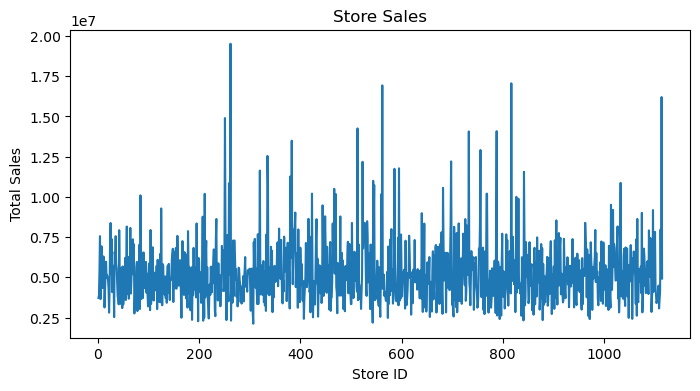

In [22]:
#Overview of all store sales

plt.figure(figsize=(8,4))
store_train.groupby(['Store'])['Sales'].sum().plot()
plt.title('Store Sales')
plt.ylabel('Total Sales')
plt.xlabel('Store ID')
plt.show()

In [23]:
#Grouping by store number and sum of all the sales
#sorting by most sales to least sales

store_train.groupby(['Store'])['Sales'].sum().sort_values(ascending=False)

Store
262     19516842
817     17057867
562     16927322
1114    16202585
251     14896870
          ...   
263      2306075
208      2302052
198      2268273
543      2179287
307      2114322
Name: Sales, Length: 1115, dtype: int64

The stores with the most sales and the stores with the sales will be compare for patterns.

In [24]:
#Top stores

top_stores = store_train.groupby(['Store'])['Sales'].sum().sort_values(ascending=False).head().index.to_list()
print(top_stores)

bottom_stores = store_train.groupby(['Store'])['Sales'].sum().sort_values(ascending=False).tail().index.to_list()
print(bottom_stores)

[262, 817, 562, 1114, 251]
[263, 208, 198, 543, 307]


In [25]:
# df store train date

store_date = store_train.set_index('Date', drop=True)
store_date.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionSince,Promo2Since,Promo2StartMonth
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,c,a,...,NaN,NaN,NaN,2015,7,31,31,82.0,0.00,0
2015-07-31,2,5,6064,625,1,1,0,1,a,a,...,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,92.0,64.15,1
2015-07-31,3,5,8314,821,1,1,0,1,a,a,...,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,103.0,51.92,1
2015-07-31,4,5,13995,1498,1,1,0,1,c,c,...,NaN,NaN,NaN,2015,7,31,31,70.0,0.00,0
2015-07-31,5,5,4822,559,1,1,0,1,a,a,...,NaN,NaN,NaN,2015,7,31,31,3.0,0.00,0


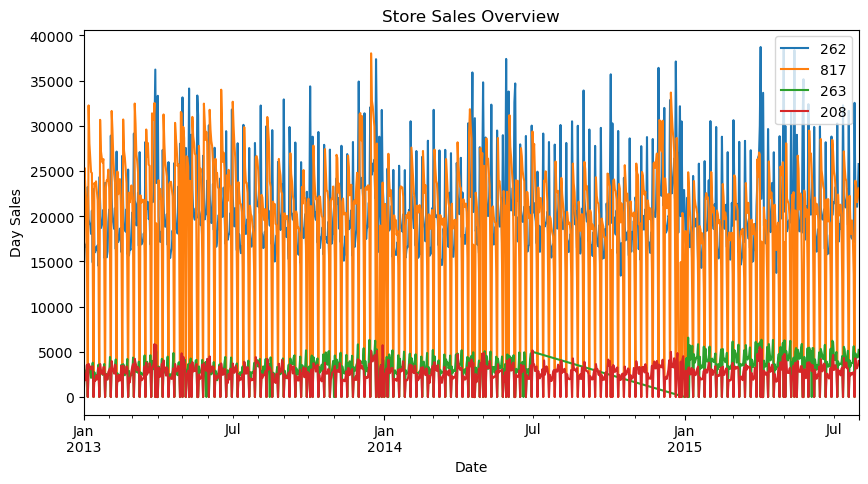

In [26]:
#Plotting sales over time for top 5 stores

plt.figure(figsize=(10,5))

for top in top_stores[:2]:
    #plt.figure(figsize=(8,3))
    store_date[store_date['Store']==top]['Sales'].plot(legend=True, label=top)
for bottom in bottom_stores[:2]:
    #plt.figure(figsize=(8,3))
    store_date[store_date['Store']==bottom]['Sales'].plot(legend=True, label=bottom)    

plt.title('Store Sales Overview')
plt.ylabel('Day Sales')
plt.xlabel('Date')
plt.show()

Large difference in sales per day from companies with a lot of sales and fewer sales. This is to be expeceted.


### Feature Engineering


In [27]:
print('Train Feat: ', store_train.columns)
print('\n')
print('Test Feat: ', store_test.columns)

Train Feat:  Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionSince', 'Promo2Since', 'Promo2StartMonth'],
      dtype='object')


Test Feat:  Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Year', 'Month',
       'Day', 'WeekOfYear', 'CompetitionSince', 'Promo2Since',
       'Promo2StartMonth'],
      dtype='object')


In [28]:
#Combin test and training data to process both at the same time

full_df = store_train.append(store_test, ignore_index=True)
full_df

/var/folders/t3/m14fghtd0fs5gl_s5tzd3h500000gn/T/ipykernel_3045/3003068157.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df = store_train.append(store_test, ignore_index=True)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionSince,Promo2Since,Promo2StartMonth,Id
0,1,5,2015-07-31,5263.0,555.0,1.0,1,0,1,c,...,NaN,NaN,2015,7,31,31,82.0,0.00,0,NaN
1,2,5,2015-07-31,6064.0,625.0,1.0,1,0,1,a,...,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,92.0,64.15,1,NaN
2,3,5,2015-07-31,8314.0,821.0,1.0,1,0,1,a,...,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,103.0,51.92,1,NaN
3,4,5,2015-07-31,13995.0,1498.0,1.0,1,0,1,c,...,NaN,NaN,2015,7,31,31,70.0,0.00,0,NaN
4,5,5,2015-07-31,4822.0,559.0,1.0,1,0,1,a,...,NaN,NaN,2015,7,31,31,3.0,0.00,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058292,1111,6,2015-08-01,NaN,NaN,1.0,0,0,0,a,...,2013.0,"Jan,Apr,Jul,Oct",2015,8,1,31,14.0,24.00,0,41084.0
1058293,1112,6,2015-08-01,NaN,NaN,1.0,0,0,0,c,...,NaN,NaN,2015,8,1,31,112.0,0.00,0,41085.0
1058294,1113,6,2015-08-01,NaN,NaN,1.0,0,0,0,a,...,NaN,NaN,2015,8,1,31,0.0,0.00,0,41086.0
1058295,1114,6,2015-08-01,NaN,NaN,1.0,0,0,0,a,...,NaN,NaN,2015,8,1,31,0.0,0.00,0,41087.0


In [29]:
# Dropping the additional features
# Also dropping Competition and Promo features
    #data was previously processed

drop_lst = ['Id','Customers','CompetitionOpenSinceYear',
            'CompetitionOpenSinceMonth', 'Promo2SinceYear',
           'Promo2SinceWeek', 'PromoInterval']

full_df.drop(drop_lst, axis=1, inplace=True)
full_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'Promo2', 'Year', 'Month', 'Day', 'WeekOfYear', 'CompetitionSince',
       'Promo2Since', 'Promo2StartMonth'],
      dtype='object')

#### Handel Missing Data

In [30]:
# Overview of missing data: count and percentage

total_missing = full_df.isnull().sum()
percent_missing = (full_df.isnull().sum() / len(full_df) * 100)

missing_df = pd.DataFrame({'Total Missing': total_missing,
                          'Percent Missing': percent_missing})

print('Percentage of Training Data: ', len(store_train)/(len(store_train)+len(store_test)))

missing_df.sort_values(['Total Missing'],ascending=False).head(12)

Percentage of Training Data:  0.9611753600359824


,Total Missing,Percent Missing
StateHoliday,131072,12.385181
Sales,41088,3.882464
CompetitionDistance,2738,0.258718
Open,11,0.001039
Store,0,0.000000
Year,0,0.000000
Promo2Since,0,0.000000
CompetitionSince,0,0.000000
WeekOfYear,0,0.000000
Day,0,0.000000


In [31]:
# List of numeric features with null values

num_null = []

for feat in full_df.columns:
    if full_df[feat].dtypes == 'int' or full_df[feat].dtypes == 'float':
        if full_df[feat].isnull().sum() > 0:
            num_null.append(feat)

#Droping sales since it is the output
num_null.remove('Sales')

num_null

['Open', 'CompetitionDistance']

/var/folders/t3/m14fghtd0fs5gl_s5tzd3h500000gn/T/ipykernel_3045/1982292449.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(full_df[feat])


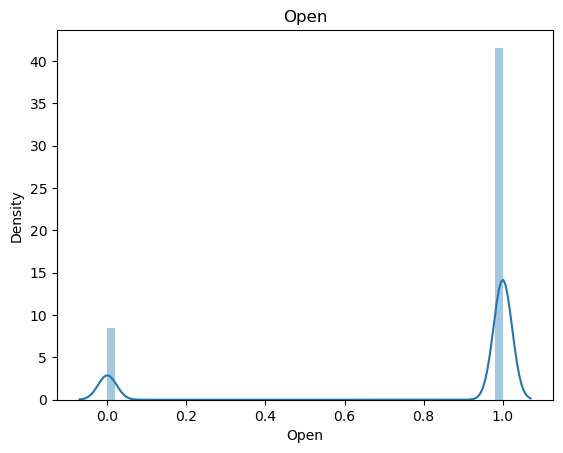

/var/folders/t3/m14fghtd0fs5gl_s5tzd3h500000gn/T/ipykernel_3045/1982292449.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(full_df[feat])


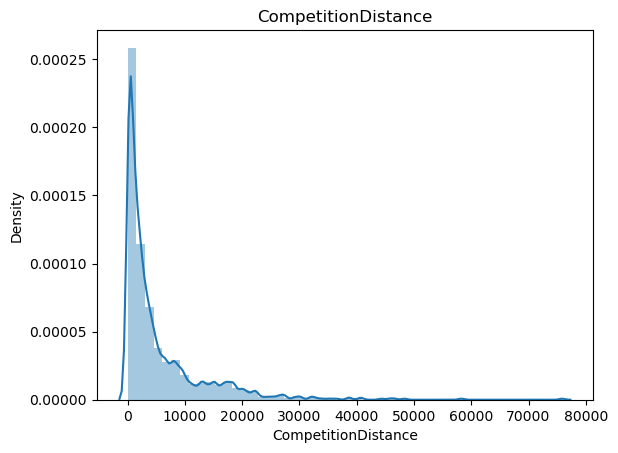

In [32]:
# Looking at the distribution plots for all missing numeric data

for feat in num_null:
    sns.distplot(full_df[feat])
    plt.title(feat)
    plt.show()

In [33]:
#Looking at data set with null 'Open'

full_df[full_df['Open'].isnull()].head()

,Store,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Year,Month,Day,WeekOfYear,CompetitionSince,Promo2Since,Promo2StartMonth
1017688,622,4,2015-09-17,NaN,NaN,1,0,0,a,c,NaN,0,2015,9,17,38,0.0,0.0,0
1018544,622,3,2015-09-16,NaN,NaN,1,0,0,a,c,NaN,0,2015,9,16,38,0.0,0.0,0
1019400,622,2,2015-09-15,NaN,NaN,1,0,0,a,c,NaN,0,2015,9,15,38,0.0,0.0,0
1020256,622,1,2015-09-14,NaN,NaN,1,0,0,a,c,NaN,0,2015,9,14,38,0.0,0.0,0
1021968,622,6,2015-09-12,NaN,NaN,0,0,0,a,c,NaN,0,2015,9,12,37,0.0,0.0,0



All the null values for the feature 'Open' come from Store #622 and is found in the test data set.


In [34]:
full_df[(full_df['Open']==0) & (full_df['Store']==622)].head(10)

df_622_closed = full_df[(full_df['Open']==0) & (full_df['Store']==622)]
df_622_closed

,Store,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Year,Month,Day,WeekOfYear,CompetitionSince,Promo2Since,Promo2StartMonth
6196,622,7,2015-07-26,0.0,0.0,0,0,0,a,c,NaN,0,2015,7,26,30,0.0,0.0,0
14001,622,7,2015-07-19,0.0,0.0,0,0,0,a,c,NaN,0,2015,7,19,29,0.0,0.0,0
21806,622,7,2015-07-12,0.0,0.0,0,0,0,a,c,NaN,0,2015,7,12,28,0.0,0.0,0
29611,622,7,2015-07-05,0.0,0.0,0,0,0,a,c,NaN,0,2015,7,5,27,0.0,0.0,0
37416,622,7,2015-06-28,0.0,0.0,0,0,0,a,c,NaN,0,2015,6,28,26,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033096,622,7,2015-08-30,NaN,0.0,0,0,0,a,c,NaN,0,2015,8,30,35,0.0,0.0,0
1039088,622,7,2015-08-23,NaN,0.0,0,0,0,a,c,NaN,0,2015,8,23,34,0.0,0.0,0
1045080,622,7,2015-08-16,NaN,0.0,0,0,0,a,c,NaN,0,2015,8,16,33,0.0,0.0,0
1051072,622,7,2015-08-09,NaN,0.0,0,0,0,a,c,NaN,0,2015,8,9,32,0.0,0.0,0


In [35]:
# the day of week appears to be constant - checking

df_622_closed['DayOfWeek'].value_counts()

7    141
4      8
1      6
5      6
3      3
2      1
Name: DayOfWeek, dtype: int64


My assumption was incorrect, there doesn't appear to be a pattern for which days are closed for store #622.


In [36]:
#Looking to see if there are any sales values when open is 0.
# When 'Open' is 0 that means the store was closed

full_df['Sales'][full_df['Open']==0].sum()

0.0

In [37]:
#Looking at the balance of open and closed for store #622

full_df['Open'][full_df['Store']==622].value_counts()

1.0    814
0.0    165
Name: Open, dtype: int64


The missing data for the feature 'Open' is in the test data file, this means I can't use the value of sales to more accuaratly determing if the missing data is 0 or 1. When the store is closed the 'Sales' value is 0. The percentage of open for store #622 is 83.15%. With both of these reasons I am assining 1 to all missing values of 'Open'


In [38]:
#filling in all missing values of Open with 1

full_df['Open'].fillna(1, inplace=True)
full_df['Open'].isnull().sum()

0

In [39]:
# Looking at data set with null 'CompetitionDistance'
# Looking to see how many different stores have null competition

full_df['Store'][full_df['CompetitionDistance'].isnull()].value_counts()

622    990
291    942
879    806
Name: Store, dtype: int64

In [40]:
#Looking to see if the store has any competition distance

print('competition distance: ', full_df['CompetitionDistance'][full_df['Store']==622].value_counts())
print('competition distance: ', full_df['CompetitionDistance'][full_df['Store']==291].value_counts())
print('competition distance: ', full_df['CompetitionDistance'][full_df['Store']==879].value_counts())

competition distance:  Series([], Name: CompetitionDistance, dtype: int64)
competition distance:  Series([], Name: CompetitionDistance, dtype: int64)
competition distance:  Series([], Name: CompetitionDistance, dtype: int64)


In [41]:
full_df['CompetitionDistance'].describe()

count    1.055559e+06
mean     5.416824e+03
std      7.697163e+03
min      2.000000e+01
25%      7.100000e+02
50%      2.330000e+03
75%      6.880000e+03
max      7.586000e+04
Name: CompetitionDistance, dtype: float64

In [42]:
full_df['CompetitionDistance'].value_counts().head(10)

250.0     11504
50.0       7776
350.0      7776
190.0      7736
1200.0     7710
90.0       6930
180.0      6882
330.0      6698
150.0      6514
1070.0     5940
Name: CompetitionDistance, dtype: int64

In [43]:
print("How Many stores have a Compe Distance of 250: ",
      full_df['Store'][full_df['CompetitionDistance']==250].nunique())
print("How Many stores have a Compe Distance of 50: ",
      full_df['Store'][full_df['CompetitionDistance']==50].nunique())
print("How Many stores have a Compe Distance of 1200: ",
      full_df['Store'][full_df['CompetitionDistance']==1200].nunique())

How Many stores have a Compe Distance of 250:  12
How Many stores have a Compe Distance of 50:  8
How Many stores have a Compe Distance of 1200:  9


In [44]:
dist_10 = sum(full_df['CompetitionDistance'].value_counts().index.tolist()[:10])/10
dist_5 = sum(full_df['CompetitionDistance'].value_counts().index.tolist()[:5])/5

print('Top 10 average distance: ', dist_10)
print('Top 5 average distance: ', dist_5)

Top 10 average distance:  386.0
Top 5 average distance:  408.0


/var/folders/t3/m14fghtd0fs5gl_s5tzd3h500000gn/T/ipykernel_3045/233361032.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(full_df[feat])


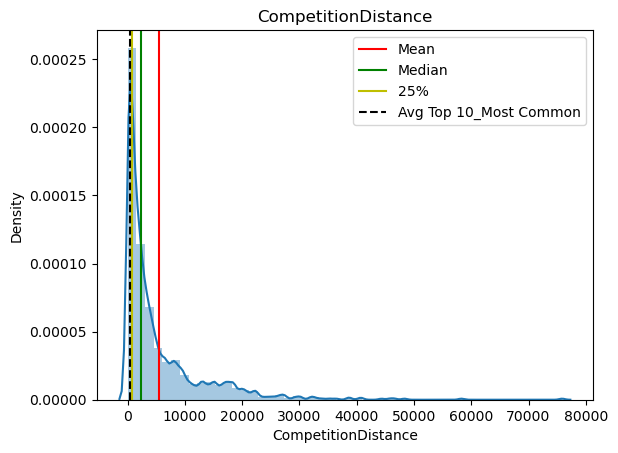

In [45]:

dist_mean = full_df['CompetitionDistance'].mean()
dist_median = full_df['CompetitionDistance'].median()
dist_mode = full_df['CompetitionDistance'].mode()

#f, (ax_box, ax_hist) = plt.subplots(1, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})
#f, ax_hist = plt.subplots()
ax = sns.distplot(full_df[feat])
ax.axvline(dist_mean, color='r', linestyle='-', label="Mean")
ax.axvline(dist_median, color='g', linestyle='-', label="Median")
#ax.axvline(dist_mode, color='b', linestyle='--', label="Mode")
ax.axvline(710, color='y', linestyle='-', label="25%")
ax.axvline(386, color='black', linestyle='--', label="Avg Top 10_Most Common")

ax.legend()

plt.title('CompetitionDistance')
plt.show()

In [46]:
print('Total Number of Stores: ', full_df['Store'].nunique())
print('Number of Stores Under Distance 386: ', full_df['Store'][full_df['CompetitionDistance']<386].nunique())
print('Number of Stores Under Distance 408: ', full_df['Store'][full_df['CompetitionDistance']<408].nunique())
print('Number of Stores Under Distance 710: ', full_df['Store'][full_df['CompetitionDistance']<710].nunique())

Total Number of Stores:  1115
Number of Stores Under Distance 386:  179
Number of Stores Under Distance 408:  184
Number of Stores Under Distance 710:  275



None of the stores have any data associated with competition distance that are missing. The average distance of the top 10 most common stores is 386. The top 5 most common stores have a distance of 408. The top 25% of stores have a distance of 710.  

There are a few different methods to solve this:
 - Use the mean or median distance value - this way the competition is not considered to close or far
     - distribution plot is left skewed
     - not recommened to avoid data leakage
 - Random Sampling
     - would keep the distribution plot the same
 - Apply classifier algorithm or unsupervised ML technique
     - Histogram based Gradient-boosting Classifier
     - K Nearest Neighbour Imputation
     - Random Forest Imputation

I don't beleive there is enough features (a lot of the features are dates) to use a classifier or unsupervised technique. The missing values for the 3 stores will be filled in with 710 since it covers the 25% of distances and 25% of the most common stores.

In [47]:
# Filling in missing competition distances

full_df['CompetitionDistance'].fillna(710, inplace=True)
full_df['CompetitionDistance'].isnull().sum()

0

In [48]:
# The final featrues with missing values is StateHoliday

print('Is missing: ', full_df['StateHoliday'].isnull().sum())
print(full_df['StateHoliday'].value_counts())

Is missing:  131072
0    895995
a     20440
b      6690
c      4100
Name: StateHoliday, dtype: int64


In [49]:
#Looking at dates for the stateHoliday values

print('Number of stores with missing State Holidays: ',
     len(full_df['Store'][full_df['StateHoliday'].isnull()].value_counts().index.tolist()))

full_df['Store'][full_df['StateHoliday'].isnull()].value_counts().tail()

Number of stores with missing State Holidays:  1115


859     58
879     58
884     58
890     58
1019    58
Name: Store, dtype: int64

In [50]:
full_df['StateHoliday'][full_df['Store']==859].value_counts()

0    718
a     22
b      6
c      2
Name: StateHoliday, dtype: int64


Not all the stores have missing state holiday information. Given more time would improve by matching dates with missing values to the previous or following years StateHoliday values.


In [51]:
#Since about 12% are missing
# Filling in all missing values with 'null'
# Another option would be to fill in with '0'
#  since it was the most common category for StateHoliday

full_df['StateHoliday'].fillna('null', inplace=True)
full_df['StateHoliday'].isnull().sum()

0

In [52]:
full_df['StateHoliday'].value_counts()

0       895995
null    131072
a        20440
b         6690
c         4100
Name: StateHoliday, dtype: int64


#### Categorical Features


In [54]:
# List of categorical features

cat_lst = [feat for feat in full_df.columns if full_df[feat].dtype=='O']

print(cat_lst)

full_df[cat_lst]

['StateHoliday', 'StoreType', 'Assortment']


,StateHoliday,StoreType,Assortment
0,0,c,a
1,0,a,a
2,0,a,a
3,0,c,c
4,0,a,a
...,...,...,...
1058292,0,a,a
1058293,0,c,c
1058294,0,a,c
1058295,0,a,c


In [55]:
full_df['Assortment'].value_counts()

a    557749
c    491822
b      8726
Name: Assortment, dtype: int64

In [56]:
# Since Assortment is an ordinal feature
#Using label encoding

assort_map = {'a':1, 'b':2, 'c':3}
full_df['Assortment'] = full_df['Assortment'].map(assort_map)
full_df['Assortment'].value_counts()

1    557749
3    491822
2      8726
Name: Assortment, dtype: int64

In [57]:
# StoreType

full_df['StoreType'].value_counts()

a    573755
d    327024
c    141112
b     16406
Name: StoreType, dtype: int64

In [58]:
# StateHoliday

full_df['StateHoliday'] = full_df['StateHoliday'].str.strip()
full_df['StateHoliday'].value_counts()

0       895995
null    131072
a        20440
b         6690
c         4100
Name: StateHoliday, dtype: int64

In [59]:
# Since StateHoliday and StoreType is a Nominal Feature - using one hot encoder

dummy_lst = ['StoreType', 'StateHoliday']

dummy_df = pd.get_dummies(full_df[dummy_lst])
full_df = pd.concat([full_df, dummy_df], axis=1)
#full_df.head()

In [60]:
# dropping extra dummy features
# don't need dummies of all the feature, can drop 1

drop_dummy = ['StateHoliday_c', 'StoreType_b']

full_df.drop(drop_dummy,axis=1,inplace=True)
full_df.head()

,Store,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,CompetitionSince,Promo2Since,Promo2StartMonth,StoreType_a,StoreType_c,StoreType_d,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_null
0,1,5,2015-07-31,5263.0,1.0,1,0,1,c,1,...,82.0,0.00,0,0,1,0,1,0,0,0
1,2,5,2015-07-31,6064.0,1.0,1,0,1,a,1,...,92.0,64.15,1,1,0,0,1,0,0,0
2,3,5,2015-07-31,8314.0,1.0,1,0,1,a,1,...,103.0,51.92,1,1,0,0,1,0,0,0
3,4,5,2015-07-31,13995.0,1.0,1,0,1,c,3,...,70.0,0.00,0,0,1,0,1,0,0,0
4,5,5,2015-07-31,4822.0,1.0,1,0,1,a,1,...,3.0,0.00,0,1,0,0,1,0,0,0


In [61]:
# dropping original categorical features

full_df.drop(dummy_lst,axis=1,inplace=True)
full_df.head()

,Store,DayOfWeek,Date,Sales,Open,Promo,SchoolHoliday,Assortment,CompetitionDistance,Promo2,...,CompetitionSince,Promo2Since,Promo2StartMonth,StoreType_a,StoreType_c,StoreType_d,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_null
0,1,5,2015-07-31,5263.0,1.0,1,1,1,1270.0,0,...,82.0,0.00,0,0,1,0,1,0,0,0
1,2,5,2015-07-31,6064.0,1.0,1,1,1,570.0,1,...,92.0,64.15,1,1,0,0,1,0,0,0
2,3,5,2015-07-31,8314.0,1.0,1,1,1,14130.0,1,...,103.0,51.92,1,1,0,0,1,0,0,0
3,4,5,2015-07-31,13995.0,1.0,1,1,3,620.0,0,...,70.0,0.00,0,0,1,0,1,0,0,0
4,5,5,2015-07-31,4822.0,1.0,1,1,1,29910.0,0,...,3.0,0.00,0,1,0,0,1,0,0,0


In [62]:
full_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Open', 'Promo', 'SchoolHoliday',
       'Assortment', 'CompetitionDistance', 'Promo2', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionSince', 'Promo2Since', 'Promo2StartMonth',
       'StoreType_a', 'StoreType_c', 'StoreType_d', 'StateHoliday_0',
       'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_null'],
      dtype='object')

#### Scale / Tranformation

In [ ]:
stop
https://towardsdatascience.com/transformation-scaling-of-numeric-features-intuition-7f4436e8e074


#### Spliting Back to Train and Test Data Sets



In [ ]:
# Spliting the data frame back in to test and train data sets.
#Exporting the new test and train data sets to be used with feature selection and machine learning models.

#splitting the data back in to train and test data frames
df_test = full_df[full_df['Sales'].isnull()]
df_train = full_df[~full_df['Sales'].isnull()]

#print(df_test.head())
#print(df_train.head())


In [ ]:
# Exporting the new train and test CSV file
#df_test.to_csv(data_file_path+'cleaned_test.csv', index=False)
#df_train.to_csv(data_file_path+'cleaned_train.csv',index=False)